# Figure 2

### Danielle Denisko

In [1]:
import os
from IPython.display import Image
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib_venn import venn2,venn3
from scipy.stats.contingency import odds_ratio
from scipy.stats import ks_2samp, ttest_ind, combine_pvalues
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import numpy as np
import zepid
import pyranges as pr
from pybedtools import BedTool

from generate_enrichment_plots import *
from generate_exon_alu_df import *
from io_utils import *
from general_plots import *
from alu_exon_characterization import *
from mfe import *
from statistics_test import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from io_utils import MyMagic
from IPython import get_ipython

ipy = get_ipython()
ipy.register_magics(MyMagic)

#### Paths

In [2]:
data_dir                          = "../"
hexevent_dir                      = os.path.join(data_dir, "iralu/")
pickle_dir                        = os.path.join(data_dir, "pickles/")
image_dir                         = os.path.join(data_dir, "images")
dataset_dir                       = os.path.join(data_dir, "datasets/")

ascot_psi_csv                     = os.path.join(hexevent_dir, "gtex_psi.csv")
ascot_psi_df                      = pd.read_csv(ascot_psi_csv)
tissue_psi_cols                   = list(ascot_psi_df.columns)[12:68]  # 56 tissues
non_tissue_cols                   = set(list(ascot_psi_df.columns)) - set(tissue_psi_cols)

maxentscan_3ss_all_mfe            = open_pickle_enrich_dct('maxentscan_3ss_all_mfe_240916.pkl', pickle_dir)  # 240531
maxentscan_5ss_all_mfe            = open_pickle_enrich_dct('maxentscan_5ss_all_mfe_240916.pkl', pickle_dir)  # 240531

rediportal_bed = BedTool(os.path.join(dataset_dir, "TABLE1_hg38-rediportal.bed"))
xstreme_dir    = os.path.join(dataset_dir, "xstreme")
#ref_fasta      = "/reference_databases/ReferenceGenome/GRCh38/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa"

In [3]:
windows_subset_1000 = open_pickle_enrich_dct('240221-test_windows_subset_1000.pkl', pickle_dir)
windows_subset_2000 = open_pickle_enrich_dct('240221-test_windows_subset_2000.pkl', pickle_dir)
windows_subset_5000 = open_pickle_enrich_dct('240221-test_windows_subset_5000.pkl', pickle_dir)

In [4]:
bed_cols_fasta = ["exon_chr", "upstream_alu_start", "downstream_alu_end", "names", "score", "exon_strand"]
bed_dir        = os.path.join(dataset_dir, "bed_dir")

def add_names_col_mfe(df, w, df_name):
    """ Add a column that will be used as an identifier to rejoin the MFE results to the original dataframes.

    Originally, only contained (df['upstream_alu_subfamily'] + df['upstream_alu_strand']  + \
            ':' + df['downstream_alu_subfamily'] + df['downstream_alu_strand'])
    but have since added indices of the original dataframes.

    Pickle these original dataframes in the same dirs as the output beds, so we can rejoin them more easily.
    """
    return (df['upstream_alu_subfamily'] + df['upstream_alu_strand']  + \
            ":" + df['downstream_alu_subfamily'] + df['downstream_alu_strand'] + \
            ":" + df["index"].apply(str) + \
            ":" + w + \
            ":" + df_name)


bed_dfs_dct      = {}
w_list           = ["5kb", "1kb", "2kb"]
w_dcts           = [windows_subset_5000, windows_subset_1000, windows_subset_2000]
df_names_extract = ["skippable", "constitutive", 
                    "skippable_inverted", "constitutive_inverted", 
                    "skippable_noninverted", "constitutive_noninverted"]

# Uncomment this section to write out to BED files
for w, w_dct in zip(w_list, w_dcts):
    bed_dfs_dct[w] = {}
    #pickle_enrich_dct(w_dct, f"{w}-dct.pkl", bed_dir)
    for df_name in df_names_extract:
        bed_dfs_dct[w][df_name] = w_dct[df_name].reset_index().copy()
        bed_dfs_dct[w][df_name]["names"] = add_names_col_mfe(df=bed_dfs_dct[w][df_name], w=w, df_name=df_name)
        bed_dfs_dct[w][df_name]["score"] = 1
#        bed_dfs_dct[w][df_name][bed_cols_fasta].to_csv(os.path.join(bed_dir, f"{w}-{df_name}.bed"), sep='\t', header=False, index=False)

In [5]:
mfe_dir               = os.path.join(bed_dir, "mfe_summary")

w_open_dct            = {}
w_open_list           = ["1kb", "2kb", "5kb"]
df_names_open         = ["skippable_inverted",    "constitutive_inverted", 
                         "skippable_noninverted", "constitutive_noninverted"]

for w in w_open_list:
    w_open_dct[w]  = {}
    # open original dct of dfs (those that were used for generating BEDs)
    w_original_dct = open_pickle_enrich_dct(f"{w}-dct.pkl", bed_dir) #["constitutive"]
    
    for df_name in df_names_open:
        print(f"w={w}; df_name={df_name}")
        # open MFE results
        dir_df = open_pickle_enrich_dct(f"{w}-{df_name}-dir-df.pickle", mfe_dir)
        dir_df["index"] = dir_df["index"].astype(int)
        dir_df.sort_values(by="index", ascending=True, inplace=True)

        # w_original_dct[df_name] and dir_df should be 1-to-1
        print(f"{len(w_original_dct[df_name])} == {len(dir_df)}")
        #assert len(w_original_dct[df_name]) == len(dir_df)
        if len(w_original_dct[df_name]) != len(dir_df):
            print(f"^the above lengths do not match")

        # merge the two dataframes and return as a dictionary entry
        w_original_df = w_original_dct[df_name].reset_index()
        w_original_df["index"]              = w_original_df["index"].astype("int64")
        w_original_df["upstream_alu_start"] = w_original_df["upstream_alu_start"].astype("int64")

        dir_df["index"]                     = dir_df["index"].astype("int64")
        dir_df["alu1_start"]                = dir_df["alu1_start"].astype("int64")
        
        #w_open_dct[w][df_name] = w_original_dct[df_name].reset_index().merge(dir_df, on="index", how="inner")
        w_open_dct[w][df_name] = (
            w_original_df
            .merge(dir_df, 
                   left_on=["index", "exon_chr", "upstream_alu_start"], 
                   right_on=["index", "chr", "alu1_start"], 
                   how="inner")
        )

w=1kb; df_name=skippable_inverted
13443 == 13443
w=1kb; df_name=constitutive_inverted
9176 == 9176
w=1kb; df_name=skippable_noninverted
15177 == 15177
w=1kb; df_name=constitutive_noninverted
12095 == 12095
w=2kb; df_name=skippable_inverted
43095 == 43090
^the above lengths do not match
w=2kb; df_name=constitutive_inverted
28991 == 28991
w=2kb; df_name=skippable_noninverted
47585 == 47582
^the above lengths do not match
w=2kb; df_name=constitutive_noninverted
34953 == 34863
^the above lengths do not match
w=5kb; df_name=skippable_inverted
167447 == 167076
^the above lengths do not match
w=5kb; df_name=constitutive_inverted
109467 == 109375
^the above lengths do not match
w=5kb; df_name=skippable_noninverted
183671 == 183217
^the above lengths do not match
w=5kb; df_name=constitutive_noninverted
123026 == 122730
^the above lengths do not match


In [6]:
def perc_failed(frac_success):
    print(f"{(1-frac_success)*100:.2f}%")
    return

perc_failed(47485/47585)
perc_failed(167205/167447)
perc_failed(109308/109467)
perc_failed(183431/183671)
perc_failed(122849/123026)

0.21%
0.14%
0.15%
0.13%
0.14%


In [7]:
bed_random_dir        = os.path.join(dataset_dir, "bed_random_dir")
mfe_random_dir        = os.path.join(bed_random_dir, "random_sets/", "mfe_summary")

w_open_dct_random            = {}
w_open_list_random           = ["1kb"]
df_names_open_random         = ["skippable_inverted", "constitutive_inverted", 
                                "skippable_noninverted", "constitutive_noninverted"]

for w in w_open_list_random:
    w_open_dct_random[w]  = {}
    # open original dct of dfs (those that were used for generating BEDs)
    w_original_dct = open_pickle_enrich_dct(f"{w}-dct.pkl", bed_random_dir)
    
    for df_name in df_names_open_random:
        print(f"random; w={w}; df_name={df_name}")
        # open MFE results
        dir_df = open_pickle_enrich_dct(f"random-{w}-{df_name}-dir-df.pickle", mfe_random_dir)
        dir_df["index"] = dir_df["index"].astype(int)
        dir_df.sort_values(by="index", ascending=True, inplace=True)

        # w_original_dct[df_name] and dir_df should be 1-to-1
        print(f"{len(w_original_dct[df_name])} == {len(dir_df)}")
        #assert len(w_original_dct[df_name]) == len(dir_df)
        if len(w_original_dct[df_name]) != len(dir_df):
            print(f"^the above lengths do not match")

        w_original_df = w_original_dct[df_name].reset_index()

        # merge the two dataframes and return as a dictionary entry
        w_open_dct_random[w][df_name] = w_original_dct[df_name].reset_index().merge(dir_df, on="index", how="inner")
        #w_open_dct_random[w][df_name] = pd.concat([w_original_df, dir_df], axis=0, ignore_index=True)

random; w=1kb; df_name=skippable_inverted
13443 == 13411
^the above lengths do not match
random; w=1kb; df_name=constitutive_inverted
9176 == 9176
random; w=1kb; df_name=skippable_noninverted
15177 == 15177
random; w=1kb; df_name=constitutive_noninverted
12095 == 12095


In [8]:
perc_failed(13411/13443)

0.24%


In [9]:
print("Total processed:", 
len(w_open_dct["1kb"]["skippable_inverted"]) + \
    len(w_open_dct["1kb"]["skippable_noninverted"]) + \
        len(w_open_dct["1kb"]["constitutive_inverted"]) + \
            len(w_open_dct["1kb"]["constitutive_noninverted"]))
print("Total skippable:", len(w_open_dct["1kb"]["skippable_inverted"]) + len(w_open_dct["1kb"]["skippable_noninverted"]))
print("Skippable inverted:",len(w_open_dct["1kb"]["skippable_inverted"]))
print("Skippable non-inverted:",len(w_open_dct["1kb"]["skippable_noninverted"]))
print("Total constitutive::",len(w_open_dct["1kb"]["constitutive_inverted"]) + len(w_open_dct["1kb"]["constitutive_noninverted"]))
print("Total inverted:", len(w_open_dct["1kb"]["skippable_inverted"]) + len(w_open_dct["1kb"]["constitutive_inverted"]))
print("Total non-inverted:", len(w_open_dct["1kb"]["skippable_noninverted"]) + len(w_open_dct["1kb"]["constitutive_noninverted"]))

Total processed: 49891
Total skippable: 28620
Skippable inverted: 13443
Skippable non-inverted: 15177
Total constitutive:: 21271
Total inverted: 22619
Total non-inverted: 27272


In [10]:
print(len(w_open_dct["1kb"]["skippable_inverted"]))
print(len(w_open_dct["1kb"]["skippable_noninverted"]))
print(len(w_open_dct["1kb"]["constitutive_inverted"]))
print(len(w_open_dct["1kb"]["constitutive_noninverted"]))

13443
15177
9176
12095


In [11]:
print(len(groupby_exons(w_open_dct["1kb"]["skippable_inverted"])["index"].rename('Skippable\ninverted')))
print(len(groupby_exons(w_open_dct["1kb"]["skippable_noninverted"])["index"].rename('Skippable\nnon-inverted')))
print(len(groupby_exons(w_open_dct["1kb"]["constitutive_inverted"])["index"].rename('Constitutive\ninverted')))
print(len(groupby_exons(w_open_dct["1kb"]["constitutive_noninverted"])["index"].rename('Constitutive\nnon-inverted')))

7033
7694
5318
6842


#### Figure 2C

In [12]:
def replace_with_subscript(text):
    """Generated by ChatGPT
    """
    parts = text.split(' vs ')
    new_parts = []
    for part in parts:
        subparts = part.split('_')
        subscripted_text = f'{subparts[0]}'
        for subpart in subparts[1:]:
            subscripted_text += f'$_{{\mathrm{{{subpart}}}}}$'
        new_parts.append(subscripted_text)
    return ' vs '.join(new_parts)


def plot_cohens_d(df, ax=None):
    tick_params_width = 0.25
    tick_params_length = 1
    tick_params_pad = 2
    axis_label_pad = 2

    fontsize_min = 5
    plt.rcParams['font.family'] = 'DejaVu Sans'

    blue="#0077BB"
    light_blue="#86B4CF"
    orange="#EE7733"
    light_orange="#EEC5AE"

    # customPalette = [blue, light_blue, orange, light_orange]

    custom_colour_labels = {replace_with_subscript("S vs C"): "black", 
                            replace_with_subscript("Inv vs Non-inv"): "black",
                            replace_with_subscript("S_inv vs S_non-inv"): blue,
                            replace_with_subscript("C_inv vs C_non-inv"): orange,
                            replace_with_subscript("S_inv vs C_inv"): "black",
                            replace_with_subscript("S_non-inv vs C_non-inv"): "black",
                            replace_with_subscript("S_inv vs Random"): blue,
                            replace_with_subscript("S_non-inv vs Random"): light_blue,
                            replace_with_subscript("C_inv vs Random"): orange,
                            replace_with_subscript("C_non-inv vs Random"): light_orange}

    sns.set_style("whitegrid")
    sns.set_theme() #font_scale=1.2
    sns.set_style('ticks')

    #plt.figure(figsize=(4, 6))  # Adjust figure size as needed

    sns.scatterplot(data=df, x='index', y='d', color="black", s=2) 

    if ax is None:
        ax = plt.gca()  
    
    for tick_label in ax.get_xticklabels():
        label_text = tick_label.get_text()
        color = custom_colour_labels[label_text]
        tick_label.set_color(color)

    ax.set_ylim(None, 1)
    ticks = np.arange(-2., 1.01, 0.5)  # Adjust range as needed
    ax.set_yticks(ticks)

    #plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=90, labelsize=fontsize_min, 
                   length=tick_params_length, width=tick_params_width, pad=tick_params_pad)
    ax.tick_params(axis='y', labelsize=fontsize_min, 
                   length=tick_params_length, width=tick_params_width, pad=tick_params_pad)
    
    ax.set_xlabel("", fontsize=fontsize_min, labelpad=axis_label_pad)
    ax.set_ylabel("Cohen's d", fontsize=fontsize_min, labelpad=axis_label_pad)

    ax.xaxis.grid(False)
    ax.yaxis.grid(True, linewidth=0.25)

    for spine in ax.spines.values():
        spine.set_linewidth(0.25)

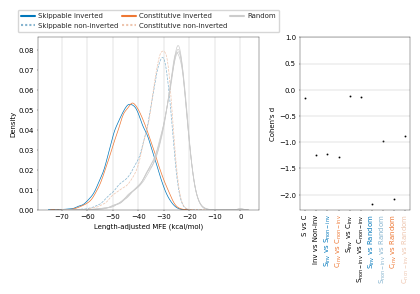

In [13]:
import mfe
import general_plots
import statistics_test
reload(mfe)
reload(general_plots)
reload(statistics_test)
from mfe import *
from general_plots import *
from statistics_test import *

mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (150/scaling_factor) / mm_per_in
target_height_in = (70/scaling_factor) /mm_per_in

width_ratios = [2, 1]
fig, axs = plt.subplots(1, 2, figsize=(target_width_in, target_height_in), #(15,4)
                        gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.25})

w_open_list = ["1kb"]
cohens_d_dct = {}
cohens_d_dct, mfe_dct_1kb = create_mfe_dfs("1kb", cohens_d_dct, w_open_dct, w_open_dct_random, 
                                           plot=True, print_stats=True, ax=axs[0])

mapping = {"skippable_vs_constitutive": "S vs C", 
           "inverted_vs_noninverted": "Inv vs Non-inv",
           "skippable_inverted_vs_skippable_noninverted": "S_inv vs S_non-inv",
           "constitutive_inverted_vs_constitutive_noninverted": "C_inv vs C_non-inv",
           "skippable_inverted_vs_constitutive_inverted": "S_inv vs C_inv",
           "skippable_noninverted_vs_constitutive_noninverted": "S_non-inv vs C_non-inv",
           "skippable_inverted_vs_random": "S_inv vs Random",
           "skippable_noninverted_vs_random": "S_non-inv vs Random",
           "constitutive_inverted_vs_random": "C_inv vs Random",
           "constitutive_noninverted_vs_random": "C_non-inv vs Random"}

cohens_d_1kb_df = pd.DataFrame.from_dict(cohens_d_dct["1kb"], orient="index")
cohens_d_1kb_df.reset_index(inplace=True)

cohens_d_1kb_df['index'] = cohens_d_1kb_df['index'].map(mapping)
cohens_d_1kb_df['index'] = cohens_d_1kb_df['index'].apply(replace_with_subscript)

plot_cohens_d(cohens_d_1kb_df, ax=axs[1])

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2c_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2c_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

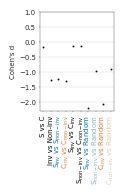

In [14]:
mm_per_in = 25.4
scaling_factor = 1.23
target_width_in = (30/scaling_factor) / mm_per_in
target_height_in = (40/scaling_factor) /mm_per_in

width_ratios = [1]
fig, axs = plt.subplots(1, 1, figsize=(target_width_in, target_height_in),
                        gridspec_kw={'width_ratios': width_ratios})

mapping = {"skippable_vs_constitutive": "S vs C", 
           "inverted_vs_noninverted": "Inv vs Non-inv",
           "skippable_inverted_vs_skippable_noninverted": "S_inv vs S_non-inv",
           "constitutive_inverted_vs_constitutive_noninverted": "C_inv vs C_non-inv",
           "skippable_inverted_vs_constitutive_inverted": "S_inv vs C_inv",
           "skippable_noninverted_vs_constitutive_noninverted": "S_non-inv vs C_non-inv",
           "skippable_inverted_vs_random": "S_inv vs Random",
           "skippable_noninverted_vs_random": "S_non-inv vs Random",
           "constitutive_inverted_vs_random": "C_inv vs Random",
           "constitutive_noninverted_vs_random": "C_non-inv vs Random"}

cohens_d_1kb_df = pd.DataFrame.from_dict(cohens_d_dct["1kb"], orient="index")
cohens_d_1kb_df.reset_index(inplace=True)

cohens_d_1kb_df['index'] = cohens_d_1kb_df['index'].map(mapping)
cohens_d_1kb_df['index'] = cohens_d_1kb_df['index'].apply(replace_with_subscript)

plot_cohens_d(cohens_d_1kb_df, ax=axs)

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2c-cohensd_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2c-cohensd_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

In [15]:
cohens_d_1kb_df

,index,t,z,d
0,S vs C,"(-16.41775258485042, 1.05554820415277e-60)","(-16.340605693285088, 2.537313917941293e-60)",-0.147928
1,Inv vs Non-inv,"(-138.11481285830715, 0.0)","(-139.11217429666937, 0.0)",-1.251068
2,S$_{\mathrm{inv}}$ vs S$_{\mathrm{non-inv}}$,"(-103.22307444355076, 0.0)","(-103.51724021698872, 0.0)",-1.226045
3,C$_{\mathrm{inv}}$ vs C$_{\mathrm{non-inv}}$,"(-91.04875209847184, 0.0)","(-92.54254179259651, 0.0)",-1.281167
4,S$_{\mathrm{inv}}$ vs C$_{\mathrm{inv}}$,"(-8.865831062637879, 4.1131083401577034e-19)","(-8.862009417131159, 3.9292479740811797e-19)",-0.120004
5,S$_{\mathrm{non-inv}}$ vs C$_{\mathrm{non-inv}}$,"(-10.927788044224954, 4.8611633863366495e-28)","(-10.836440472974175, 1.1564808348519239e-27)",-0.132084
6,S$_{\mathrm{inv}}$ vs Random,"(-174.9109999609364, 0.0)","(-174.31415913004335, 0.0)",-2.184616
7,S$_{\mathrm{non-inv}}$ vs Random,"(-80.26235271998249, 0.0)","(-80.10069680582384, 0.0)",-0.976335
8,C$_{\mathrm{inv}}$ vs Random,"(-148.68000611503618, 0.0)","(-149.96031416029888, 0.0)",-2.076064
9,C$_{\mathrm{non-inv}}$ vs Random,"(-68.41297873727011, 0.0)","(-68.41297873727011, 0.0)",-0.879732


#### Figure 2B

In [16]:
df_skip = mfe_dct_1kb["df_skip"]
df_const = mfe_dct_1kb["df_const"]

df_skip["exon_type"] = "skippable"
df_const["exon_type"] = "constitutive"

df_all = pd.concat([df_skip, df_const], ignore_index=True)
df_all["exon_length"] = df_all["exon_end"] - df_all["exon_start"]

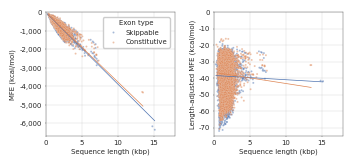

In [17]:
import general_plots
reload(general_plots)
from general_plots import *

mm_per_in = 25.4
scaling_factor = 1.23

target_width_in = (120/scaling_factor) / mm_per_in
target_height_in = (50/scaling_factor) /mm_per_in

width_ratios = [1, 1]
fig, axs = plt.subplots(1, 2, figsize=(target_width_in, target_height_in), #(15,4)
                        gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.3})

generate_mfe_raw_plot(df_all, legend=True, ax=axs[0])
generate_mfe_corrected_plot(df_all, legend=False, ax=axs[1])

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2b_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2b_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

#### Figure S2A

2kb:
5kb:


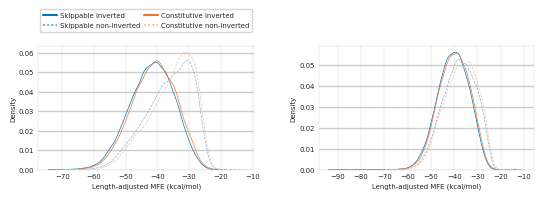

In [18]:
import mfe
import general_plots
reload(mfe)
reload(general_plots)
from mfe import *
from general_plots import *

mm_per_in = 25.4
scaling_factor = 1.23

target_width_in = (200/scaling_factor) / mm_per_in
target_height_in = (50/scaling_factor) /mm_per_in

width_ratios = [1, 1]
fig, axs = plt.subplots(1, 2, figsize=(target_width_in, target_height_in), #(16,6)
                        gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.3}) #wspace:0.2

cohens_d_dct_2kb, mfe_dct_2kb = create_mfe_dfs_suppl("2kb", w_open_dct, ax=axs[0], 
                                                     plot=True, print_stats=False, legend=True)
cohens_d_dct_5kb, mfe_dct_5kb = create_mfe_dfs_suppl("5kb", w_open_dct, ax=axs[1], 
                                                     plot=True, print_stats=False, legend=False)

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figureS2a_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figureS2a_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

#### Figure 2D

In [19]:
pd.set_option('display.max_columns', None)

In [20]:
# Split exon_boundary into 3 separate columns
ascot_psi_df[["exon_boundary_chr", "exon_boundary_pos"]] = (ascot_psi_df["exon_boundary"]
                                                            .str.split(":", expand=True))
ascot_psi_df[["exon_boundary_start", "exon_boundary_end"]] = (ascot_psi_df["exon_boundary_pos"]
                                                              .str.split("-", expand=True))

# Choose cassette exons only (remove other AS types)
ascot_psi_numeric_cols = ["exon_boundary_start", "exon_boundary_end", "exon_length"]
ascot_psi_df_cassette = ascot_psi_df[ascot_psi_df["cassette_exon"] == "Yes"].copy()
ascot_psi_df_cassette[ascot_psi_numeric_cols] = (
    ascot_psi_df_cassette[ascot_psi_numeric_cols].apply(pd.to_numeric)
)

# I filtered on cassette here, since we don't care about other AS events
ascot_psi_df_prexonboundary = (
    pr.PyRanges(ascot_psi_df_cassette.rename(columns={"exon_boundary_chr": "Chromosome",
                                             "exon_boundary_start": "Start",
                                             "exon_boundary_end": "End",
                                             "exon_strand": "Strand"}
                                   )
               )
)

In [21]:
bed6_cols                 = ['chr', 'start', 'end', 'gene', 'score', 'strand']

mfe_all_ascot_prexonboundary_s10 = (
    pr.PyRanges(df_all
                .dropna(subset=["exon_{}".format(i) for i in bed6_cols], how="all")
                .rename(columns={"exon_chr": "Chromosome",
                                 "exon_start": "Start",
                                 "exon_end": "End",
                                 "exon_strand": "Strand"})
                )
    .join(ascot_psi_df_prexonboundary, slack=10, report_overlap=True)
)

# We continue with slack=10 exon boundary dfs
# Force exon lengths to be the same between both merged dfs
mfe_all_ascot_prexonboundary_s10 = mfe_all_ascot_prexonboundary_s10.as_df()
mfe_all_ascot_prexonboundary_s10 = mfe_all_ascot_prexonboundary_s10[mfe_all_ascot_prexonboundary_s10["exon_length"] == mfe_all_ascot_prexonboundary_s10["exon_length_b"]]

# Replace all "-1" entries from the ASCOT db with np.NaN (since they indicate missing values)
mfe_all_ascot_prexonboundary_s10[tissue_psi_cols] = (
    mfe_all_ascot_prexonboundary_s10[tissue_psi_cols].replace({-1: np.NaN})
)

# Calculate min, max, mean, median, and interquartile range (IQR)
mfe_all_ascot_prexonboundary_s10["tissue_psi_mean"] = mfe_all_ascot_prexonboundary_s10[tissue_psi_cols].mean(axis=1)
mfe_all_ascot_prexonboundary_s10["tissue_psi_max"] = mfe_all_ascot_prexonboundary_s10[tissue_psi_cols].max(axis=1)
mfe_all_ascot_prexonboundary_s10["tissue_psi_min"] = mfe_all_ascot_prexonboundary_s10[tissue_psi_cols].min(axis=1)
mfe_all_ascot_prexonboundary_s10["tissue_psi_median"] = mfe_all_ascot_prexonboundary_s10[tissue_psi_cols].median(axis=1)

mfe_all_ascot_prexonboundary_s10["tissue_psi_q25"] = mfe_all_ascot_prexonboundary_s10[tissue_psi_cols].quantile(q=0.25,axis=1)
mfe_all_ascot_prexonboundary_s10["tissue_psi_q75"] = mfe_all_ascot_prexonboundary_s10[tissue_psi_cols].quantile(q=0.75,axis=1)
mfe_all_ascot_prexonboundary_s10["tissue_psi_iqr"] = mfe_all_ascot_prexonboundary_s10["tissue_psi_q75"] - mfe_all_ascot_prexonboundary_s10["tissue_psi_q25"]

# Convert columns to numeric
mfe_all_ascot_prexonboundary_s10["exon_length"] = pd.to_numeric(mfe_all_ascot_prexonboundary_s10["exon_length"])

In [22]:
bins = [0, 50, 250, 10000]
labels = ["short", "medium", "long"]
mfe_all_ascot_prexonboundary_s10["exon_length_category"] = pd.cut(mfe_all_ascot_prexonboundary_s10["exon_length"], bins=bins, labels=labels)

#display(mfe_all_ascot_prexonboundary_s10["exon_length_category"].value_counts())

for l in ["short", "medium", "long"]:
    #print(l)
    #display(mfe_all_ascot_prexonboundary_s10[mfe_all_ascot_prexonboundary_s10["exon_length_category"] == l]["exon_type"].value_counts())
    #display(mfe_all_ascot_prexonboundary_s10[mfe_all_ascot_prexonboundary_s10["exon_length_category"] == l]["inversion"].value_counts())
    continue

In [23]:
maxentscan_3ss_all_mfe = maxentscan_3ss_all_mfe.apply(pd.Series).rename(columns={0:"3ss_seq", 1:"3ss_score"})
maxentscan_5ss_all_mfe = maxentscan_5ss_all_mfe.apply(pd.Series).rename(columns={0:"5ss_seq", 1:"5ss_score"})
all_mfe_maxentscan = pd.concat([mfe_all_ascot_prexonboundary_s10, maxentscan_3ss_all_mfe, maxentscan_5ss_all_mfe], axis="columns")

all_mfe_maxentscan["exon_definition"] = (
    np.where(((all_mfe_maxentscan["3ss_score"] > 5) & (all_mfe_maxentscan["5ss_score"] > 5)), "strong", "weak")
)
all_mfe_maxentscan["exon_definition_3ss"] = np.where((all_mfe_maxentscan["3ss_score"] > 5), "strong", "weak")
all_mfe_maxentscan["exon_definition_5ss"] = np.where((all_mfe_maxentscan["5ss_score"] > 5), "strong", "weak")

all_mfe_maxentscan.rename(
    columns={"3ss_score": "maxentscan_3ss_score", "5ss_score": "maxentscan_5ss_score"}, inplace=True)

def movassat_mes_categories(row):
    if row['maxentscan_3ss_score'] < 6 and row['maxentscan_5ss_score'] < 6:
        return 'WW'
    elif row['maxentscan_3ss_score'] < 6 and row['maxentscan_5ss_score'] > 8:
        return 'WS'
    elif row['maxentscan_3ss_score'] > 8 and row['maxentscan_5ss_score'] < 6:
        return 'SW'
    elif row['maxentscan_3ss_score'] > 8 and row['maxentscan_5ss_score'] > 8:
        return 'SS'

MES_order = ["SS", "WS", "SW", "WW"]
all_mfe_maxentscan['MES_category'] = all_mfe_maxentscan.apply(movassat_mes_categories, axis=1)
all_mfe_maxentscan["MES_3ss"] = np.where((all_mfe_maxentscan["maxentscan_3ss_score"] > 8), "strong", "weak") #XXX revise
all_mfe_maxentscan["MES_5ss"] = np.where((all_mfe_maxentscan["maxentscan_5ss_score"] > 8), "strong", "weak")

In [24]:
#  I tried to move this to the mfe module but couldn't due to "stats" library error
def linear_regression_exon_def(df, inversion, xaxis, target_width=None, target_height=None):
    """ inversion: inverted or non-inverted 
        xaxis: minimum or median
    """
    tick_params_width = 0.25
    tick_params_length = 1
    tick_params_pad = 2
    axis_label_pad = 2

    fontsize_min = 5
    plt.rcParams['font.family'] = 'DejaVu Sans'

    custom_palette = sns.color_palette("husl", 4)
    rotated_palette = custom_palette[-1:] + custom_palette[:-1]  # Rotate by 1 position

    if xaxis == "minimum":
        x_col = "tissue_psi_min"
        x_col_label = "Minimum tissue PSI"
    elif xaxis == "median":
        x_col = "tissue_psi_median"
        x_col_label = "Median tissue PSI"
    
    sns.set_style("ticks")

    aspect_ratio = target_width / target_height

    g = sns.lmplot(
        data=df[df["inversion"] == inversion],
        x=x_col, y="seq_corrected_mfe", #x="tissue_psi_min"
        hue="MES_category", hue_order=MES_order,
        scatter_kws={"alpha": 0.5, "facecolor": "none", "s": 1}, #"edgecolor": "black"
        line_kws={"linewidth": 0.5},
        legend=False,
        palette=rotated_palette,
        ci=None
    ) #height=target_height, aspect=aspect_ratio
    
    g.fig.set_size_inches(target_width, target_height)
    mes_categories = df["MES_category"].unique()
    annotations = {"all": []}

    for mes_category in MES_order:
        subset = df[
            (df["inversion"] == inversion) &
            (df["MES_category"] == mes_category)
        ]
        if not subset.empty:
            try:
                slope, intercept, r_value, p_value, std_err = stats.linregress(subset[x_col], subset["seq_corrected_mfe"])
                r_squared = r_value**2
                p_adj = min(1, 4*p_value)  # manual Bonferroni correction --> num_tests * p_value < 0.05 but cannot exceed 1
                #annotation = f"{mes_category} → Slope: {slope:.2f}; R²: {r_squared:.2f}; p_adj: {p_adj:.2e}"
                annotation = f"{mes_category}: R²={r_squared:.2f}, p_adj={p_adj:.2e}"
                #annotations[exon_length_category].append(annotation) 
                annotations["all"].append(annotation)
            except ValueError:
                pass

    for ax in g.axes.flatten():
        annotation_text = "\n\n".join(annotations["all"])
        pos = ax.get_position()
        center_x = (pos.x0 + pos.x1) / 2

        # g.fig.text(
        #     center_x, pos.y0 - 0.18, annotation_text,
        #     ha='center', va='top', fontsize=fontsize_min,
        #     bbox=dict(boxstyle="round,pad=0.3", edgecolor=None, facecolor="khaki")
        # )
        g.fig.text(
            1.33, 0.45, annotation_text,
            ha='center', va='top', fontsize=fontsize_min,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor=None, facecolor="khaki")
        )
    
    g.fig.legend(
        loc='center left',
        bbox_to_anchor=(0.95, 0.75), #(0.95, 0.5)
        ncol=1,
        frameon=True,
        fontsize=fontsize_min,
        title='Exon definition',
        title_fontsize=fontsize_min,
        columnspacing=0.5,
        handletextpad=0.3,
        borderpad=0.7
    )
    g.set_axis_labels(x_col_label, "Length-adjusted MFE")
    
    g.set_xlabels(x_col_label, fontsize=fontsize_min, labelpad=axis_label_pad)
    g.set_ylabels("Length-adjusted MFE", fontsize=fontsize_min, labelpad=axis_label_pad)
    
    plt.tick_params(axis='both', which='major', labelsize=fontsize_min, length=tick_params_length, width=tick_params_width, pad=tick_params_pad)

    for spine in ax.spines.values():
        spine.set_linewidth(0.25)

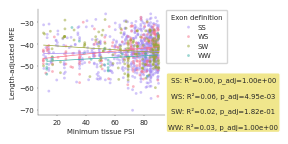

In [25]:
mm_per_in = 25.4
scaling_factor = 1.23

target_width_in = (50/scaling_factor) / mm_per_in
target_height_in = (40/scaling_factor) /mm_per_in

iqr_quantile = 0
filtered_data = all_mfe_maxentscan[
    (all_mfe_maxentscan["exon_type"] == "skippable") &
    #(all_mfe_maxentscan["inversion"] == "inverted") &
    (all_mfe_maxentscan["tissue_psi_min"] <= 90) &
    (all_mfe_maxentscan["tissue_psi_min"] >= 10) &
    (all_mfe_maxentscan["tissue_psi_iqr"] >= all_mfe_maxentscan["tissue_psi_iqr"].quantile(q=iqr_quantile))
]

linear_regression_exon_def(filtered_data, inversion="inverted", xaxis="minimum", target_width=target_width_in, target_height=target_height_in)

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2d_2024-10-23_min.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2d_2024-10-23_min.png"), dpi=300, bbox_inches = "tight")
plt.show()

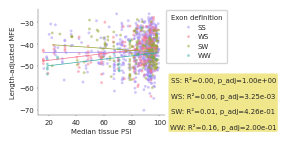

In [26]:
iqr_quantile = 0
filtered_data = all_mfe_maxentscan[
    (all_mfe_maxentscan["exon_type"] == "skippable") &
    #(all_mfe_maxentscan["inversion"] == "inverted") &
    (all_mfe_maxentscan["tissue_psi_min"] <= 90) &
    (all_mfe_maxentscan["tissue_psi_min"] >= 10) &
    (all_mfe_maxentscan["tissue_psi_iqr"] >= all_mfe_maxentscan["tissue_psi_iqr"].quantile(q=iqr_quantile))
]

linear_regression_exon_def(filtered_data, inversion="inverted", xaxis="median", target_width=target_width_in, target_height=target_height_in)
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2d_2024-10-23_med.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2d_2024-10-23_med.png"), dpi=300, bbox_inches = "tight")
plt.show()

In [27]:
print("\nTotal pairs:", all_mfe_maxentscan.groupby(["exon_type"]).size().sum())
print("\n", all_mfe_maxentscan.groupby(["inversion"]).size())
print("\n", all_mfe_maxentscan.groupby(["exon_type"]).size())
print("\nSkippable:\n")
print(all_mfe_maxentscan[all_mfe_maxentscan["exon_type"] == "skippable"].groupby(["inversion"]).size())
print("\n10<=min_PSI<=90:", len(all_mfe_maxentscan[(all_mfe_maxentscan["exon_type"] == "skippable") & (all_mfe_maxentscan["tissue_psi_min"] <= 90) & (all_mfe_maxentscan["tissue_psi_min"] >= 10)]))


Total pairs: 12471

 inversion
inverted        5987
non-inverted    6484
dtype: int64

 exon_type
constitutive    2576
skippable       9895
dtype: int64

Skippable:

inversion
inverted        4806
non-inverted    5089
dtype: int64

10<=min_PSI<=90: 3405


In [28]:
print(filtered_data.groupby(["exon_type"]).size()) #.sum()
print(filtered_data.groupby(["inversion"]).size())
print("\n",filtered_data.groupby(["MES_category"]).size())
print("\n",filtered_data[filtered_data["inversion"] == "inverted"].groupby(["MES_category"]).size())
print("\n",1615-filtered_data[filtered_data["inversion"] == "inverted"].groupby(["MES_category"]).size().sum())

exon_type
skippable    3405
dtype: int64
inversion
inverted        1615
non-inverted    1790
dtype: int64

 MES_category
SS    1255
SW     354
WS     389
WW      54
dtype: int64

 MES_category
SS    639
SW    184
WS    177
WW     24
dtype: int64

 591


#### Figure S2B

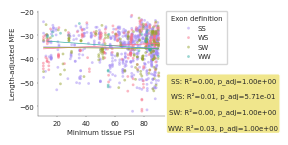

In [29]:
mm_per_in = 25.4
scaling_factor = 1.23

target_width_in = (50/scaling_factor) / mm_per_in
target_height_in = (40/scaling_factor) /mm_per_in

iqr_quantile = 0
filtered_data = all_mfe_maxentscan[
    (all_mfe_maxentscan["exon_type"] == "skippable") &
    (all_mfe_maxentscan["tissue_psi_min"] <= 90) &
    (all_mfe_maxentscan["tissue_psi_min"] >= 10) &
    (all_mfe_maxentscan["tissue_psi_iqr"] >= all_mfe_maxentscan["tissue_psi_iqr"].quantile(q=iqr_quantile))
]

linear_regression_exon_def(filtered_data, inversion="non-inverted", xaxis="minimum", target_width=target_width_in, target_height=target_height_in)
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figureS2b_2024-10-23_min.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figureS2b_2024-10-23_min.png"), dpi=300, bbox_inches = "tight")
plt.show()

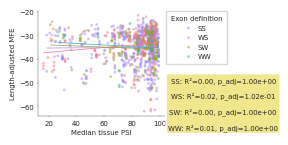

In [30]:
iqr_quantile = 0
filtered_data = all_mfe_maxentscan[
    (all_mfe_maxentscan["exon_type"] == "skippable") &
    (all_mfe_maxentscan["tissue_psi_min"] <= 90) &
    (all_mfe_maxentscan["tissue_psi_min"] >= 10) &
    (all_mfe_maxentscan["tissue_psi_iqr"] >= all_mfe_maxentscan["tissue_psi_iqr"].quantile(q=iqr_quantile))
]

linear_regression_exon_def(filtered_data, inversion="non-inverted", xaxis="median", target_width=target_width_in, target_height=target_height_in)
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figureS2b_2024-10-23_med.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figureS2b_2024-10-23_med.png"), dpi=300, bbox_inches = "tight")
plt.show()

#### Figure 2E

In [31]:
# reorder
all_mfe_maxentscan.insert(0, 'Chromosome', all_mfe_maxentscan.pop('Chromosome'))
all_mfe_maxentscan.insert(1, 'upstream_alu_start', all_mfe_maxentscan.pop('upstream_alu_start'))
all_mfe_maxentscan.insert(2, 'downstream_alu_start', all_mfe_maxentscan.pop('downstream_alu_start'))
all_mfe_maxentscan.insert(3, 'exon_gene', all_mfe_maxentscan.pop('exon_gene'))
all_mfe_maxentscan.insert(4, 'level_7', all_mfe_maxentscan.pop('level_7'))
all_mfe_maxentscan.insert(5, 'Strand', all_mfe_maxentscan.pop('Strand')) # XXX

In [32]:
all_mfe_maxentscan_redi = (
    BedTool.from_dataframe(
        #all_mfe_maxentscan[["Chromosome", "upstream_alu_start", "downstream_alu_end", "Strand"]]
        all_mfe_maxentscan
    ).intersect(rediportal_bed, c=True, s=True)
).to_dataframe(names=list(all_mfe_maxentscan.columns) + ["rediportal_count"]) # lof=True, u=True 

In [33]:
print(f"There are {len(all_mfe_maxentscan_redi):,} entries with REDI portal (RNA editing) annotations out of the original {len(all_mfe_maxentscan):,}.")

There are 12,471 entries with REDI portal (RNA editing) annotations out of the original 12,471.


In [34]:
all_mfe_maxentscan_redi["exon_type"].value_counts()

exon_type
skippable       9895
constitutive    2576
Name: count, dtype: int64

In [35]:
all_mfe_maxentscan_redi["inversion"].value_counts()

inversion
non-inverted    6484
inverted        5987
Name: count, dtype: int64

In [36]:
# Average per exon (REDIportal)

all_mfe_maxentscan_redi_grouped = all_mfe_maxentscan_redi.groupby(['Chromosome', 'Start', 'End', 'Strand']).rediportal_count.mean().reset_index()
all_mfe_maxentscan_redi_grouped.rename(columns={'rediportal_count': 'average_rediportal_count'}, inplace=True)

#display(all_mfe_maxentscan_redi_grouped)


In [37]:
iqr_quantile = 0
filtered_redi_lt50 = all_mfe_maxentscan_redi[
    (all_mfe_maxentscan_redi["exon_type"] == "skippable") &
    (all_mfe_maxentscan_redi["inversion"] == "inverted") & 
    (all_mfe_maxentscan_redi["tissue_psi_min"] <= 50) &
    (all_mfe_maxentscan_redi["tissue_psi_min"] >= 10) &
    (all_mfe_maxentscan_redi["tissue_psi_iqr"] >= all_mfe_maxentscan_redi["tissue_psi_iqr"].quantile(q=iqr_quantile))
]
filtered_redi_lt50 = filtered_redi_lt50.copy()
filtered_redi_lt50["psi_category"] = "PSI < 50%"
filtered_redi_gt50 = all_mfe_maxentscan_redi[
    (all_mfe_maxentscan_redi["exon_type"] == "skippable") &
    (all_mfe_maxentscan_redi["inversion"] == "inverted") & 
    (all_mfe_maxentscan_redi["tissue_psi_min"] <= 90) &
    (all_mfe_maxentscan_redi["tissue_psi_min"] > 50) &
    (all_mfe_maxentscan_redi["tissue_psi_iqr"] >= all_mfe_maxentscan_redi["tissue_psi_iqr"].quantile(q=iqr_quantile))
]
filtered_redi_gt50 = filtered_redi_gt50.copy()
filtered_redi_gt50["psi_category"] = "PSI > 50%"
filtered_redi = pd.concat([filtered_redi_lt50, filtered_redi_gt50], axis=0)

In [38]:
iqr_quantile = 0
filtered_redi_medlt50 = all_mfe_maxentscan_redi[
    (all_mfe_maxentscan_redi["exon_type"] == "skippable") &
    (all_mfe_maxentscan_redi["inversion"] == "inverted") & 
    (all_mfe_maxentscan_redi["tissue_psi_median"] <= 50) &
    (all_mfe_maxentscan_redi["tissue_psi_min"] <= 90) &
    (all_mfe_maxentscan_redi["tissue_psi_min"] >= 10) &
    (all_mfe_maxentscan_redi["tissue_psi_iqr"] >= all_mfe_maxentscan_redi["tissue_psi_iqr"].quantile(q=iqr_quantile))
]
filtered_redi_medlt50 = filtered_redi_medlt50.copy()
filtered_redi_medlt50["psi_category"] = "PSI < 50%"
filtered_redi_medgt50 = all_mfe_maxentscan_redi[
    (all_mfe_maxentscan_redi["exon_type"] == "skippable") &
    (all_mfe_maxentscan_redi["inversion"] == "inverted") & 
    (all_mfe_maxentscan_redi["tissue_psi_median"] > 50) &
    (all_mfe_maxentscan_redi["tissue_psi_min"] <= 90) &
    (all_mfe_maxentscan_redi["tissue_psi_min"] >= 10) &
    (all_mfe_maxentscan_redi["tissue_psi_iqr"] >= all_mfe_maxentscan_redi["tissue_psi_iqr"].quantile(q=iqr_quantile))
]
filtered_redi_medgt50 = filtered_redi_medgt50.copy()
filtered_redi_medgt50["psi_category"] = "PSI > 50%"
filtered_redi_med = pd.concat([filtered_redi_medlt50, filtered_redi_medgt50], axis=0)

In [39]:
# Moved to "general_plots"
# def plot_redi_rna_editing_burden(df, ax, show_table=True):
#     tick_params_width = 0.25
#     tick_params_length = 1
#     tick_params_pad = 2
#     axis_label_pad = 2

#     fontsize_min = 5
#     plt.rcParams['font.family'] = 'DejaVu Sans'

#     exon_def_mapping = {".": "Other", "WS": "WS", "SS":"SS", "WW":"WW", "SW":"SW"}
#     category_order = ["WS", "SS", "SW", "WW", "Other"]
#     custom_palette = ["#2ca02c", "#9467bd"]
    
#     filtered_redi = df
#     filtered_redi['MES_category_map'] = filtered_redi['MES_category'].map(exon_def_mapping)

#     if show_table:
#         ttest_upstream_redi_results = []
#         grouped_data = filtered_redi.groupby("MES_category_map")

#         for name, group in grouped_data:
#             inv1 = group[group["psi_category"] == "PSI < 50%"]["rediportal_count"]
#             inv2 = group[group["psi_category"] == "PSI > 50%"]["rediportal_count"]

#             t_stat, p_value = ttest_ind(inv1, inv2)
#             ttest_upstream_redi_results.append({"MES_category_map": name, "t_stat": t_stat, "p_value": p_value, "p_adj": p_value*5})

#         ttest_upstream_redi_results_df = pd.DataFrame(ttest_upstream_redi_results)
#         display(ttest_upstream_redi_results_df)
    
#     sns.set_style("ticks")
#     sns.violinplot(
#         data=filtered_redi, x='MES_category_map', hue="psi_category", y="rediportal_count", 
#         inner="box", order=category_order, palette=custom_palette, linewidth=0.5, ax=ax
#     )

#     ax.set_ylabel("RNA editing burden", fontsize=fontsize_min, labelpad=axis_label_pad)
#     ax.set_xlabel("Exon definition category", fontsize=fontsize_min, labelpad=axis_label_pad)

#     ax.tick_params(axis='x', labelsize=fontsize_min, 
#                    length=tick_params_length, width=tick_params_width, pad=tick_params_pad)
#     ax.tick_params(axis='y', labelsize=fontsize_min, 
#                    length=tick_params_length, width=tick_params_width, pad=tick_params_pad)

#     ax.set_ylim(-99, 500)
#     ax.tick_params(axis='both', which='both', 
#                    length=tick_params_length, width=tick_params_width, pad=tick_params_pad)
    
#     ax.yaxis.grid(True, linewidth=0.25)
#     ax.xaxis.grid(False)

#     ax.legend(title='', fancybox=True, shadow=False, borderaxespad=0., fontsize=fontsize_min)

#     for spine in ax.spines.values():
#         spine.set_linewidth(0.25)

,MES_category_map,t_stat,p_value,p_adj
0,Other,-0.291512,7.707622e-01,3.853811e+00
1,SS,-0.146652,8.834530e-01,4.417265e+00
2,SW,-1.244869,2.147804e-01,1.073902e+00
3,WS,6.106698,6.394351e-09,3.197176e-08
4,WW,-1.676069,1.078801e-01,5.394007e-01


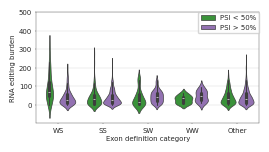

In [40]:
import general_plots
reload(general_plots)
from general_plots import *

mm_per_in = 25.4
scaling_factor = 1.23

target_width_in = (90/scaling_factor) / mm_per_in
target_height_in = (45/scaling_factor) /mm_per_in

width_ratios = [1]
fig, axs = plt.subplots(1, 1, figsize=(target_width_in, target_height_in),
                        gridspec_kw={'width_ratios': width_ratios})

plot_redi_rna_editing_burden(filtered_redi, axs, show_table=True) #filtered_redi_med

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2e_min_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2e_min_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

,MES_category_map,t_stat,p_value,p_adj
0,Other,-1.017448,3.093579e-01,1.546790
1,SS,0.030802,9.754372e-01,4.877186
2,SW,0.272156,7.858104e-01,3.929052
3,WS,5.192039,5.728261e-07,0.000003
4,WW,-1.827324,8.124862e-02,0.406243


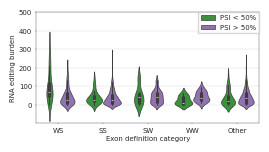

In [41]:
mm_per_in = 25.4
scaling_factor = 1.23

target_width_in = (90/scaling_factor) / mm_per_in
target_height_in = (45/scaling_factor) /mm_per_in

width_ratios = [1]
fig, axs = plt.subplots(1, 1, figsize=(target_width_in, target_height_in),
                        gridspec_kw={'width_ratios': width_ratios})

plot_redi_rna_editing_burden(filtered_redi_med, axs, show_table=True) #filtered_redi_med

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2e_med_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2e_med_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

## Figure 2F

In [42]:
# Most recent run on 09-17-24; 09-05-24; Ran this on 06-19-24
iqr_quantile = 0
filtered_data_fasta_min_lt50 = all_mfe_maxentscan[
    (all_mfe_maxentscan["exon_type"] == "skippable") &
    (all_mfe_maxentscan["inversion"] == "inverted") & 
    (all_mfe_maxentscan["tissue_psi_min"] <= 50) &
    (all_mfe_maxentscan["tissue_psi_min"] >= 10) &
    (all_mfe_maxentscan["tissue_psi_iqr"] >= all_mfe_maxentscan["tissue_psi_iqr"].quantile(q=iqr_quantile))
]

filtered_data_fasta_min_gt50 = all_mfe_maxentscan[
    (all_mfe_maxentscan["exon_type"] == "skippable") &
    (all_mfe_maxentscan["inversion"] == "inverted") & 
    (all_mfe_maxentscan["tissue_psi_min"] <= 90) &
    (all_mfe_maxentscan["tissue_psi_min"] > 50) &
    (all_mfe_maxentscan["tissue_psi_iqr"] >= all_mfe_maxentscan["tissue_psi_iqr"].quantile(q=iqr_quantile))
]

# (BedTool.from_dataframe(
#     filtered_data_fasta_min_lt50[filtered_data_fasta_min_lt50["MES_category"] == "WS"][
#     ["Chromosome", "upstream_alu_start", "downstream_alu_end", "Strand"]
#     ]
# ).getfasta(fi=ref_fasta, s=True, fo=os.path.join(xstreme_dir, "WS_inv_skippable_minpsi_10_50.fa")))

# (BedTool.from_dataframe(
#     filtered_data_fasta_min_gt50[filtered_data_fasta_min_gt50["MES_category"] == "WS"][
#     ["Chromosome", "upstream_alu_start", "downstream_alu_end", "Strand"]
#     ]
# ).getfasta(fi=ref_fasta, s=True, fo=os.path.join(xstreme_dir, "WS_inv_skippable_minpsi_50_90.fa")))

# Most recent run on 10-18-24; 09-17-24; 09-05-24; Ran this on 06-19-24
iqr_quantile = 0
filtered_data_fasta_lt50 = all_mfe_maxentscan[
    (all_mfe_maxentscan["exon_type"] == "skippable") &
    (all_mfe_maxentscan["inversion"] == "inverted") & 
    (all_mfe_maxentscan["tissue_psi_median"] <= 50) &
    (all_mfe_maxentscan["tissue_psi_min"] >= 10) &
    (all_mfe_maxentscan["tissue_psi_min"] <= 90) &
    (all_mfe_maxentscan["tissue_psi_iqr"] >= all_mfe_maxentscan["tissue_psi_iqr"].quantile(q=iqr_quantile))
]

filtered_data_fasta_gt50 = all_mfe_maxentscan[
    (all_mfe_maxentscan["exon_type"] == "skippable") &
    (all_mfe_maxentscan["inversion"] == "inverted") & 
    (all_mfe_maxentscan["tissue_psi_min"] >= 10) &
    (all_mfe_maxentscan["tissue_psi_min"] <= 90) &
    (all_mfe_maxentscan["tissue_psi_median"] > 50) &
    (all_mfe_maxentscan["tissue_psi_iqr"] >= all_mfe_maxentscan["tissue_psi_iqr"].quantile(q=iqr_quantile))
]

#(BedTool.from_dataframe(
#    filtered_data_fasta_lt50[filtered_data_fasta_lt50["MES_category"] == "WS"][
#    ["Chromosome", "upstream_alu_start", "downstream_alu_end", "exon_gene", "level_7", "Strand"]
#    ]
#).getfasta(fi=ref_fasta, s=True, fo=os.path.join(xstreme_dir, "WS_inv_skippable_minpsi_10-90_medlt50.fa")))

#(BedTool.from_dataframe(
#    filtered_data_fasta_gt50[filtered_data_fasta_gt50["MES_category"] == "WS"][
#    ["Chromosome", "upstream_alu_start", "downstream_alu_end", "exon_gene", "level_7", "Strand"]
#    ]
#).getfasta(fi=ref_fasta, s=True, fo=os.path.join(xstreme_dir, "WS_inv_skippable_minpsi_10-90_medgt50.fa")))

print(len(filtered_data_fasta_lt50[filtered_data_fasta_lt50["MES_category"] == "WS"]))
print(len(filtered_data_fasta_gt50[filtered_data_fasta_gt50["MES_category"]=="WS"]))

25
152


In [43]:
iralu_dir = os.path.join(dataset_dir, "sea_output")

sea_medlt50_tsv = os.path.join(iralu_dir, "sea-WS_inv_skippable_minpsi_10-90_medlt50.tsv")
sea_medgt50_tsv = os.path.join(iralu_dir, "sea-WS_inv_skippable_minpsi_10-90_medgt50.tsv")

sea_medlt50_df = pd.read_csv(sea_medlt50_tsv, sep="\t", comment="#")
sea_medgt50_df = pd.read_csv(sea_medgt50_tsv, sep="\t", comment="#")

sea_medlt50_df['ID_RBP'] = sea_medlt50_df['ID'].str.split('(').str[0]
sea_medgt50_df['ID_RBP'] = sea_medgt50_df['ID'].str.split('(').str[0]

sea_medlt50_df["NEG_LOG_EVALUE"] = -sea_medlt50_df["LOG_EVALUE"]
sea_medgt50_df["NEG_LOG_EVALUE"] = -sea_medgt50_df["LOG_EVALUE"]
sea_medlt50_df["neg_log10_eval"] = -np.log10(sea_medlt50_df["EVALUE"])
sea_medgt50_df["neg_log10_eval"] = -np.log10(sea_medgt50_df["EVALUE"])

sea_medlt50_df["NEG_LOG_QVALUE"] = -sea_medlt50_df["LOG_QVALUE"]
sea_medgt50_df["NEG_LOG_QVALUE"] = -sea_medgt50_df["LOG_QVALUE"]
sea_medlt50_df["neg_log10_qval"] = -np.log10(sea_medlt50_df["QVALUE"])
sea_medgt50_df["neg_log10_qval"] = -np.log10(sea_medgt50_df["QVALUE"])
sea_medlt50_df["neg_ln_qval"] = -np.log(sea_medlt50_df["QVALUE"])
sea_medgt50_df["neg_ln_qval"] = -np.log(sea_medgt50_df["QVALUE"])

In [44]:
protein_groups = {
    'HNRNP': ['HNRNPA0', 'HNRNPA1', 'HNRNPA2B1', 'HNRNPC', 'HNRNPD', 'HNRNPDL', 'HNRNPF', 
              'HNRNPH1', 'HNRNPH2', 'HNRNPH3', 'HNRNPK', 'HNRNPL', 'HNRNPLL'],
    'PCBP': ['PCBP1', 'PCBP2'],
    'SRSF': ['SRSF1', 'SRSF2', 'SRSF3', 'SRSF5', 'SRSF6', 'SRSF7', 'SRSF9'],
    'ELAVL': ['ELAVL2', 'ELAVL4'],
    'RBM': ['RBM4', 'RBM5', 'RBMX'],
    'TRA2': ['TRA2A', 'TRA2B'],
    'SRP': ['SRP19', 'SRP68'],
    'PUM': ['PUM1', 'PUM2'],
    'TIA': ['TIA1', 'TIAL1'],
    'Other': ['CELF2', 'DAZAP1', 'KHSRP', 'MBNL1', 'NELFE', 'NOVA1', 'PABPC1', 
              'PTBP1', 'SF1', 'SFPQ', 'SNRPA', 'SSB', 'TUT1', 'YBX1', 'ZFP36', 'ZRANB2']
}
protein_groups_counts = {f"{x} (m={len(y)})":y for x,y in protein_groups.items()}

#palette = sns.color_palette("Set2", n_colors=len(protein_groups))  # 'tab10', 'Set2', 'Paired'
#group_colours = dict(zip(protein_groups.keys(), palette))

palette = sns.color_palette("Set3", n_colors=len(protein_groups_counts))  # 'tab10', 'Set2', 'Paired'
group_colours = dict(zip(protein_groups_counts.keys(), palette))

def assign_protein_group(id_rbp):
    """
    Assign RBP to group for hue colour.
    """
    for group, proteins in protein_groups_counts.items():
        if id_rbp in proteins:
            return group
    return 'Unknown'  # In case there's an ID not covered

def plot_scatter_motifs(df, col, ax=None):
    """
    Plot identical cols from TSV1 vs TSV2 output of SEA (MEME Suite).
    col: neg_log10_qval, neg_log10_adjusted_pval_fisher, min_rank, avg_rank
    """
    tick_params_width = 0.25
    tick_params_length = 1
    tick_params_pad = 2
    axis_label_pad = 2

    fontsize_min = 5
    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    df['Group'] = df['ID_RBP'].apply(assign_protein_group)
    
    if col == "neg_log10_qval":
        threshold_val = -np.log10(0.05)
        axis_label = "-log10(Q-value)"
    elif col == "neg_log10_adjusted_pval_fisher":
        #threshold_val = -np.log10(0.05)
        threshold_val = 15
        axis_label = "-log10(p_adj)"
    elif col == "min_rank":
        threshold_val = 0
        axis_label = "Minimum rank"
    elif col == "avg_rank":
        threshold_val = 0
        axis_label = "Average rank"

    #significant_points = df[(df[f"{col}_tsv1"] > threshold_val) & 
    #                        (df[f"{col}_tsv2"] > threshold_val)]
    significant_points = df[(df[f"{col}_tsv1"] > threshold_val) | 
                            (df[f"{col}_tsv2"] > threshold_val)]
    
    #ax = sns.scatterplot(data=df,
    sns.scatterplot(data=df,
                    x=f"{col}_tsv1",
                    y=f"{col}_tsv2", 
                    hue='Group',
                    palette=group_colours,
                    s=2,legend=True, ax=ax)

    for _, row in significant_points.iterrows():
        jitter_x = row[f"{col}_tsv1"] #+ np.random.uniform(0, 0.1)
        jitter_y = row[f"{col}_tsv2"] + np.random.uniform(0, 0.2)
        ax.text(jitter_x, jitter_y, row['ID_RBP'], fontsize=fontsize_min, ha='center', va='bottom')
    
    ax.set_ylim(-3, 43)
    ax.set_xlim(-3, 53)
    
    ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_yticks([0, 10, 20, 30, 40])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    min_limit = min(xlim[0], ylim[0])
    max_limit = max(xlim[1], ylim[1])

    if col not in ["min_rank", "avg_rank"]:
        ax.axvline(-np.log10(0.05), color='steelblue', linestyle='--', linewidth=0.5)
        ax.axhline(-np.log10(0.05), color='steelblue', linestyle='--', linewidth=0.5)
    else:
        ax.invert_xaxis()
        ax.invert_yaxis()
    ax.plot([min_limit, max_limit], [min_limit, max_limit], linestyle='--', color='gray', linewidth=0.5)

    ax.set_ylabel(f"{axis_label} PSI > 50%", fontsize=fontsize_min, labelpad=axis_label_pad)
    ax.set_xlabel(f"{axis_label} PSI < 50%", fontsize=fontsize_min, labelpad=axis_label_pad)

    #ax.tick_params(axis='x', 
    #               labelsize=fontsize_min, 
    #               length=tick_params_length, 
    #               width=tick_params_width, 
    #               pad=tick_params_pad)
    #ax.tick_params(axis='y', 
    #               labelsize=fontsize_min, 
    #               length=tick_params_length, 
    #               width=tick_params_width, 
    #               pad=tick_params_pad)

    #ax.set_ylim(-99, 500)
    ax.tick_params(axis='both', which='both',
                   labelsize=fontsize_min, 
                   length=tick_params_length, 
                   width=tick_params_width, 
                   pad=tick_params_pad)
    
    #plt.xlabel()
    #plt.ylabel()
    #plt.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')

    custom_order = sorted(protein_groups_counts.keys(), key=lambda x: -int(x.split('=')[1][:-1]))
    
    handles, labels = ax.get_legend_handles_labels()
    ordered_handles_labels = [(h, l) for l, h in zip(labels, handles) if l in custom_order]
    ordered_handles_labels.sort(key=lambda x: custom_order.index(x[1]))
    ordered_handles, ordered_labels = zip(*ordered_handles_labels)

    ax.legend(ordered_handles, ordered_labels, title='', fancybox=True, shadow=False, borderaxespad=0., 
              fontsize=fontsize_min, markerscale=0.3, loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    for spine in ax.spines.values():
        spine.set_linewidth(0.25)
    
    coordinates_df = df[['ID_RBP', f"{col}_tsv1", f"{col}_tsv2"]]
    coordinates_df.reset_index(drop=True, inplace=True)

In [45]:
# select the row with the maximum 'LOG_EVALUE' for each ID (RBP)
sea_medlt50_df_max = sea_medlt50_df.loc[sea_medlt50_df.groupby('ID_RBP')['neg_log10_qval'].idxmax()]
sea_medgt50_df_max = sea_medgt50_df.loc[sea_medgt50_df.groupby('ID_RBP')['neg_log10_qval'].idxmax()]

sea_medlt50_df_min = sea_medlt50_df.loc[sea_medlt50_df.groupby('ID_RBP')['neg_log10_qval'].idxmin()]
sea_medgt50_df_min = sea_medgt50_df.loc[sea_medgt50_df.groupby('ID_RBP')['neg_log10_qval'].idxmin()]


def fishers_method_group(group):
    combined_pval = combine_pvalues(group['PVALUE'], method='fisher')[1]
    return pd.Series({'combined_pval_fisher': combined_pval})


sea_medlt50_df_combinedp = sea_medlt50_df.groupby('ID_RBP').apply(fishers_method_group, include_groups=False).reset_index()
sea_medgt50_df_combinedp = sea_medgt50_df.groupby('ID_RBP').apply(fishers_method_group, include_groups=False).reset_index()

sea_medlt50_df_combinedp_bh = multipletests(sea_medlt50_df_combinedp['combined_pval_fisher'], method='fdr_bh')
sea_medgt50_df_combinedp_bh = multipletests(sea_medgt50_df_combinedp['combined_pval_fisher'], method='fdr_bh')
sea_medlt50_df_combinedp['adjusted_pval_fisher'] = sea_medlt50_df_combinedp_bh[1]
sea_medgt50_df_combinedp['adjusted_pval_fisher'] = sea_medgt50_df_combinedp_bh[1]
sea_medlt50_df_combinedp['neg_log10_adjusted_pval_fisher'] = (
    -np.log10(sea_medlt50_df_combinedp['adjusted_pval_fisher'])
)
sea_medgt50_df_combinedp['neg_log10_adjusted_pval_fisher'] = (
    -np.log10(sea_medgt50_df_combinedp['adjusted_pval_fisher'])
)

min_rank_lt50 = sea_medlt50_df.groupby('ID_RBP')['RANK'].min().reset_index()
min_rank_gt50 = sea_medgt50_df.groupby('ID_RBP')['RANK'].min().reset_index()
min_rank_lt50 = min_rank_lt50.rename(columns={'RANK': 'min_rank_tsv1'})
min_rank_gt50 = min_rank_gt50.rename(columns={'RANK': 'min_rank_tsv2'})

avg_rank_lt50 = sea_medlt50_df.groupby('ID_RBP')['RANK'].mean().reset_index()
avg_rank_gt50 = sea_medgt50_df.groupby('ID_RBP')['RANK'].mean().reset_index()
avg_rank_lt50 = avg_rank_lt50.rename(columns={'RANK': 'avg_rank_tsv1'})
avg_rank_gt50 = avg_rank_gt50.rename(columns={'RANK': 'avg_rank_tsv2'})

merged_maxq_df = pd.merge(sea_medlt50_df_max, sea_medgt50_df_max, on='ID_RBP', suffixes=('_tsv1', '_tsv2'))
merged_minq_df = pd.merge(sea_medlt50_df_min, sea_medgt50_df_min, on='ID_RBP', suffixes=('_tsv1', '_tsv2'))
merged_combinedp_df = pd.merge(sea_medlt50_df_combinedp, sea_medgt50_df_combinedp, on='ID_RBP', suffixes=('_tsv1', '_tsv2'))
merged_minrank_df = pd.merge(min_rank_lt50, min_rank_gt50, on='ID_RBP')
merged_avgrank_df = pd.merge(avg_rank_lt50, avg_rank_gt50, on='ID_RBP')

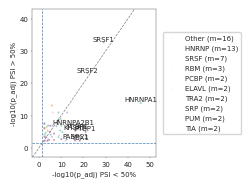

In [46]:
mm_per_in = 25.4
scaling_factor = 1.23

target_width_in = (50/scaling_factor) / mm_per_in
target_height_in = (60/scaling_factor) /mm_per_in

width_ratios = [1]
fig, axs = plt.subplots(1, 1, figsize=(target_width_in, target_height_in),
                        gridspec_kw={'width_ratios': width_ratios})

plot_scatter_motifs(merged_combinedp_df, "neg_log10_adjusted_pval_fisher", ax=axs)

#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2f_2024-10-23.svg"), bbox_inches = "tight")
#plt.savefig(os.path.join(image_dir, "manuscript", "2024-10-23", "figure2f_2024-10-23.png"), dpi=300, bbox_inches = "tight")
plt.show()

In [47]:
(5.728261e-07)*5

2.8641305e-06